<a href="https://colab.research.google.com/github/doyoung1122/24-2/blob/Introduction-of-A.I/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5%EA%B8%B0%EC%B4%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#필요한 라이브러리 설치(yfinance)
!pip install yfinance
#라이브러리 임포트
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

pca사용하지않기
train(2016~2019년까지)
<br/>test(2020년)
<br/>test(2023년)
둘의 accuracy를 비교

In [4]:
# 애플 주가 데이터 수집(필요한건 종가와 거래량이므로 close와 volume만 사용)
ticker = 'AAPL'
start_date = '2021-01-01'
data = yf.download(ticker, start=start_date)
data = data[['Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [5]:
# 데이터 복사 및 주가 변동률 계산
data_copy = data.copy()
data_copy['Previous Close'] = data_copy['Close'].squeeze().shift(1)
data_copy['Change'] = ((data_copy['Close'].squeeze() - data_copy['Previous Close']) / data_copy['Previous Close']) * 100
data_copy = data_copy.dropna()

In [6]:
data_copy['Label'] = (data_copy['Change'] > 0).astype(int)

In [7]:
# Calculate RSI
def calculate_rsi(df, window=14):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

RSI(Relative Strength Index)는 여러 금융상품들의 등락을 판단하는 지표
<br/>0~100%까지 나올 수 있으며, 30%이하인 경우 과매도, 70%이상일 경우 과매수(또는 20%, 80%)
<br/>따라서 70%이상인 경우 주가가 하락할 가능성이 높고, 30%이하인 경우에는 상승할 가능성이 높다.

In [8]:
data_copy['RSI'] = calculate_rsi(data_copy)

In [9]:
oil_data = yf.download('CL=F', start=start_date)  # WTI Crude Oil 심볼
data_copy['Oil_Price'] = oil_data['Close']

[*********************100%***********************]  1 of 1 completed


In [10]:
fed_funds_rate = pdr.DataReader('FEDFUNDS', 'fred', start_date)   #미국기준금리
fed_funds_rate = fed_funds_rate.reindex(data_copy.index, method='ffill')
data_copy['Federal Funds Rate'] = fed_funds_rate['FEDFUNDS']

In [11]:
#독립변수1. 거래량
#독립변수2. 변동성(일별 표준편차)
#독립변수3. 변동량
#독립변수4. RSI
#독립변수5. 미국기준금리
#독립변수6. WTI유가
data_copy['Volatility'] = data_copy['Close'].rolling(window=30).std() #지난 30일간의 표준편차
data_copy = data_copy.dropna() #결손값은 제거

In [12]:
data_copy

Price,Close,Volume,Previous Close,Change,Label,RSI,Oil_Price,Federal Funds Rate,Volatility
Ticker,AAPL,AAPL,,,,,,,
Date,,,,,,,,,
2021-02-17,130.839996,97918500,133.190002,-1.764401,0,27.524028,61.139999,0.08,4.465053
2021-02-18,129.710007,96856700,130.839996,-0.863642,0,32.528417,60.520000,0.08,4.500685
2021-02-19,129.869995,87668800,129.710007,0.123343,1,43.529367,59.240002,0.08,4.354990
2021-02-22,126.000000,103916400,129.869995,-2.979899,0,27.186076,61.490002,0.08,4.563060
2021-02-23,125.860001,158273000,126.000000,-0.111111,0,23.350792,61.669998,0.08,4.781810
...,...,...,...,...,...,...,...,...,...
2024-12-05,243.039993,40033900,243.009995,0.012345,1,82.962622,68.300003,4.64,6.154492
2024-12-06,242.839996,36870600,243.039993,-0.082290,0,95.837626,67.199997,4.64,6.565735


In [13]:
features = ['Volume', 'Volatility', 'Change', 'Oil_Price', 'RSI', 'Federal Funds Rate']
X = data_copy[features].values
y = data_copy['Label'].values

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##c변수?? 감마변수?? 커널??

##C (Regularization Parameter):
C 값이 작음: 마진이 넓어지고 더 많은 데이터가 허용 마진 내에 포함될 수 있음(과소적합 위험).
<br/>C 값이 큼: 마진이 좁아지고 데이터를 더 잘 구분하려고 함(과적합 위험).

##kernel (커널 함수):
'linear': 선형 분리.
<br/>'rbf' (기본값): 비선형 분리에 사용되는 가우시안 커널.
<br/>'poly': 다항식 커널.

##gamma:
'scale' (기본값): 특성 수에 따라 자동 계산된 값.
<br/>값이 작을수록 결정 경계가 더 부드러워지고, 클수록 더 복잡한 결정 경계를 생성.

##향후 시간이 되면 펜데믹 이전과 이후의 영향을 끼치는 것을 비교


In [ ]:
C = 1.0
gamma = 5
kernel = 'rbf'  # 커널 종류 ('linear', 'poly', 'rbf', 'sigmoid')

model = SVC(C=C, gamma=gamma, kernel=kernel)
model.fit(X_scaled, y)

SVC(gamma=5)

In [2]:
def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f"SVM Decision Boundary (Kernel={linear}, C={C}, Gamma={gamma})")
    plt.show()

Visualizing Decision Boundary using all data...


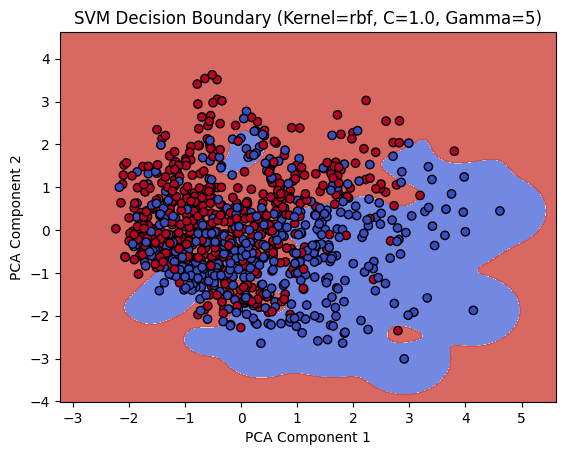

In [ ]:
#print("Visualizing Decision Boundary using all data...")
#plot_decision_boundary(X_pca, y, model)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear']
}

grid = GridSearchCV(SVC(), param_grid, cv=5, verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Best Cross-Validation Accuracy: 0.668389780154486


In [ ]:
model = SVC(C=C, gamma=gamma, kernel=kernel)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.689119170984456

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.52      0.58        79
           1       0.71      0.81      0.75       114

    accuracy                           0.69       193
   macro avg       0.68      0.66      0.67       193
weighted avg       0.68      0.69      0.68       193

